## Player Churn Prediction


### This notebook predicts player churn using multiple ML algorithms

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle


### Load data

In [2]:
df = pd.read_csv('../player_game_statistics.csv')
df.head()

,player_name,game_name,total_games_played,total_wins,total_losses,total_moves,total_time_played_minutes,win_ratio,age,gender,country,is_churned,player_level,engagement_level,win_probability
0,David Ali,battleship,37,21,16,1766,919,56.76,64,Male,South Korea,0,intermediate,73.18,0.5676
1,Mohammed Ali,battleship,88,44,44,4267,2416,50.00,51,Male,Japan,0,intermediate,100.00,0.5000
2,Amir Nguyen,battleship,136,42,94,6592,3597,30.88,18,Male,USA,0,intermediate,100.00,0.3088
3,Sophia Brown,battleship,120,86,34,6016,3259,71.67,43,Male,Brazil,0,expert,100.00,0.7167
4,Elena Garcia,reversi,19,3,16,249,244,15.79,64,Male,Japan,0,intermediate,52.48,0.1579


### Examine the data

In [3]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())

Dataset shape: (1000, 15)

First few rows:
    player_name   game_name  total_games_played  total_wins  total_losses  \
0     David Ali  battleship                  37          21            16   
1  Mohammed Ali  battleship                  88          44            44   
2   Amir Nguyen  battleship                 136          42            94   
3  Sophia Brown  battleship                 120          86            34   
4  Elena Garcia     reversi                  19           3            16   

   total_moves  total_time_played_minutes  win_ratio  age gender      country  \
0         1766                        919      56.76   64   Male  South Korea   
1         4267                       2416      50.00   51   Male        Japan   
2         6592                       3597      30.88   18   Male          USA   
3         6016                       3259      71.67   43   Male       Brazil   
4          249                        244      15.79   64   Male        Japan   

   is_c

In [4]:
df.head(10)

,player_name,game_name,total_games_played,total_wins,total_losses,total_moves,total_time_played_minutes,win_ratio,age,gender,country,is_churned,player_level,engagement_level,win_probability
0,David Ali,battleship,37,21,16,1766,919,56.76,64,Male,South Korea,0,intermediate,73.18,0.5676
1,Mohammed Ali,battleship,88,44,44,4267,2416,50.00,51,Male,Japan,0,intermediate,100.00,0.5000
2,Amir Nguyen,battleship,136,42,94,6592,3597,30.88,18,Male,USA,0,intermediate,100.00,0.3088
3,Sophia Brown,battleship,120,86,34,6016,3259,71.67,43,Male,Brazil,0,expert,100.00,0.7167
4,Elena Garcia,reversi,19,3,16,249,244,15.79,64,Male,Japan,0,intermediate,52.48,0.1579
5,John Tanaka,reversi,2,1,1,6,18,50.00,51,Male,China,1,novice,41.16,0.5000
6,John Liu,battleship,106,29,77,5086,2936,27.36,32,Male,China,0,intermediate,100.00,0.2736
7,Carlos Tanaka,battleship,123,39,84,5765,3180,31.71,27,Male,Brazil,0,intermediate,100.00,0.3171
8,Haruto Davis,chess,89,25,59,4186,3545,28.09,50,Male,USA,0,intermediate,100.00,0.2809
9,Raj Williams,chess,28,15,13,1320,1152,53.57,18,Male,Canada,0,intermediate,74.24,0.5357


### Check class distribution

In [5]:
print("\nChurn distribution:")
print(df['is_churned'].value_counts())
print("\nChurn distribution (percentage):")
print(df['is_churned'].value_counts(normalize=True) * 100)
print("\nThis shows an unbalanced dataset")


Churn distribution:
is_churned
0    941
1     59
Name: count, dtype: int64

Churn distribution (percentage):
is_churned
0    94.1
1     5.9
Name: proportion, dtype: float64

This shows an unbalanced dataset


## Data Preprocessing for Churn Prediction

In [6]:
# Convert categorical variables - use separate encoders
gender_encoder = LabelEncoder()
country_encoder = LabelEncoder()
game_encoder = LabelEncoder()

# First, fit the encoders on the unique values including 'unknown'
game_encoder.fit(list(df['game_name'].unique()) + ['unknown'])
gender_encoder.fit(list(df['gender'].unique()) + ['unknown'])
country_encoder.fit(list(df['country'].unique()) + ['unknown'])

# Function to safely transform values
def safe_transform(encoder, series):
    transformed = series.copy()
    unknown_value = len(encoder.classes_) - 1
    
    for idx, value in enumerate(series):
        try:
            transformed.iloc[idx] = encoder.transform([value])[0]
        except:
            transformed.iloc[idx] = unknown_value
    
    return transformed

# Transform the data using safe transform
df['game_encoded'] = safe_transform(game_encoder, df['game_name'])
df['gender_encoded'] = safe_transform(gender_encoder, df['gender'])
df['country_encoded'] = safe_transform(country_encoder, df['country'])

# Select features for churn prediction
features = ['total_games_played', 'win_ratio', 'total_time_played_minutes', 'total_moves',
            'gender_encoded', 'country_encoded','game_encoded', 'age']

X = df[features]
y = df['is_churned']

#### Split the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scale the features

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data by Oversampling the minority class:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Check balanced class distribution
print("\nClass distribution after SMOTE balancing (training set):")
print(pd.Series(y_train_balanced).value_counts())
print()
print()
print("Now the dataset is balanced!")


Class distribution after SMOTE balancing (training set):
is_churned
0    760
1    760
Name: count, dtype: int64


Now the dataset is balanced!


### Initialize models

In [9]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced')
}


### Train and evaluate each model

In [10]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Store results
    results[name] = {
        'Classification Report': classification_report(y_test, y_pred, zero_division=0),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Cross-validation score using stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv)
    results[name]['CV Scores'] = cv_scores
    
    print(f"\n{name} Results:")
    print("Cross-validation scores:", cv_scores.mean())
    print("\nClassification Report:")
    print(results[name]['Classification Report'])
    


Training Random Forest...

Random Forest Results:
Cross-validation scores: 0.975

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       181
           1       0.62      0.68      0.65        19

    accuracy                           0.93       200
   macro avg       0.79      0.82      0.81       200
weighted avg       0.93      0.93      0.93       200


Training Gradient Boosting...

Gradient Boosting Results:
Cross-validation scores: 0.9697368421052632

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       181
           1       0.65      0.79      0.71        19

    accuracy                           0.94       200
   macro avg       0.81      0.87      0.84       200
weighted avg       0.95      0.94      0.94       200


Training Logistic Regression...

Logistic Regression Results:
Cross-validation scores: 0.9184210526315789

Class

### Feature Importance

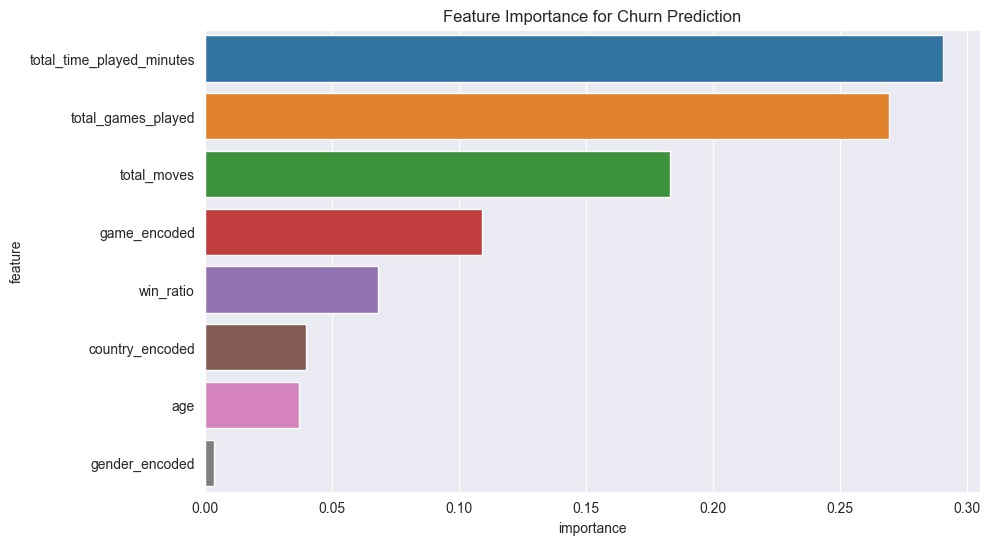

In [11]:
# Feature Importance for Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Churn Prediction')
plt.show()

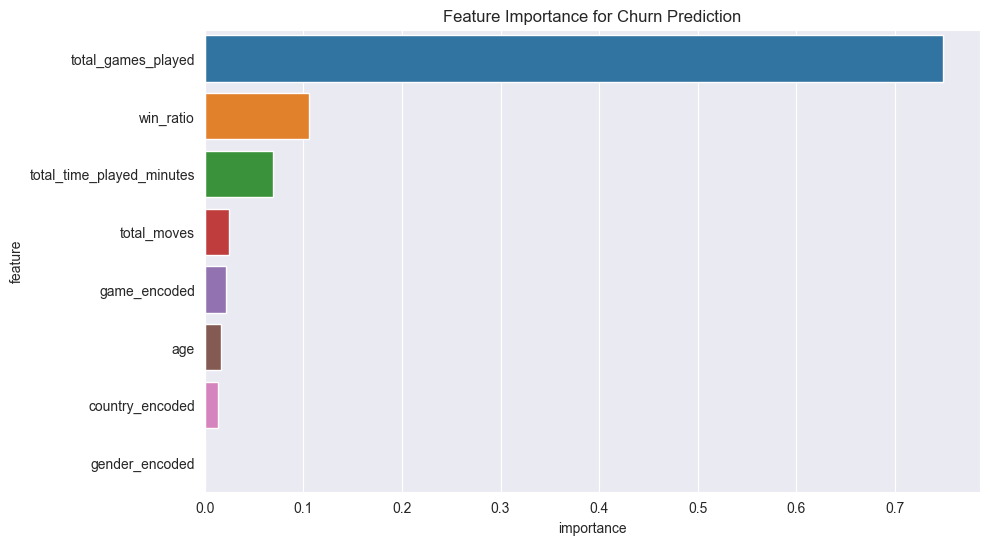

In [12]:
# Feature Importance for Gradient Boosting
rf_model = models['Gradient Boosting']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Churn Prediction')
plt.show()

In [13]:
display(y_train_balanced.value_counts())

is_churned
0    760
1    760
Name: count, dtype: int64

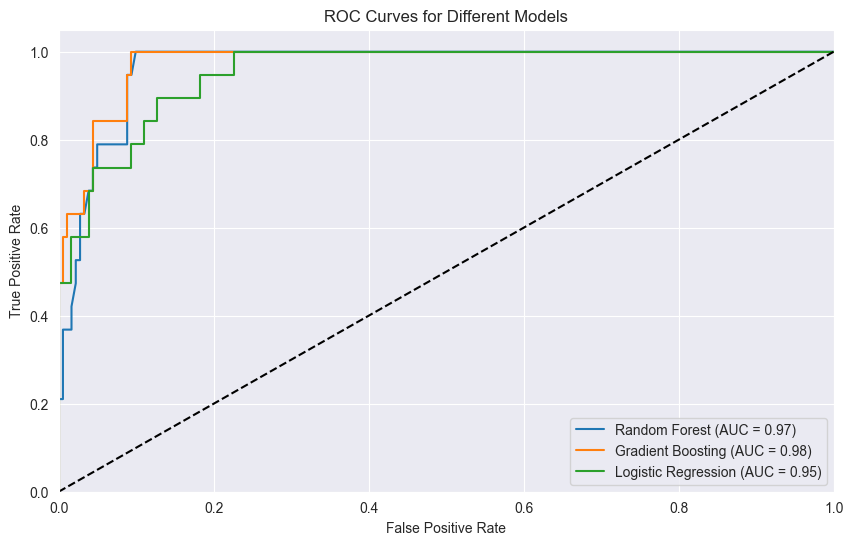

In [14]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.show()

### Select the best model based on cross-validation scores

In [15]:
best_model_name = max(results, key=lambda x: np.mean(results[x]['CV Scores']))
best_model = models[best_model_name]
best_cv_score = np.mean(results[best_model_name]['CV Scores'])

print(f"\nBest Model: {best_model_name}")
print(f"Best Cross-validation Score: {best_cv_score:.4f}")


Best Model: Random Forest
Best Cross-validation Score: 0.9750


### Save the models

In [16]:
# Save the best model
with open('../models/churn_model.pkl','wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('../models/churn_scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

# Save the label encoders
encoder_dict = {
    'gender_encoder': gender_encoder,
    'country_encoder': country_encoder,
    'game_encoder': game_encoder
}

with open('../models/churn_encoders.pkl','wb') as f:
    pickle.dump(encoder_dict, f)
    


### Loading the models

In [17]:
def load_churn_model():
    """Load the saved churn prediction model and preprocessing objects"""
    with open('../models/churn_model.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('../models/churn_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('../models/churn_encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)

    return model, scaler, encoders

### Make Predictions

In [18]:
def predict_churn(data, model, scaler, encoders):
    """
    Make churn predictions on new data

    Parameters:
    data (pd.DataFrame): DataFrame containing the required features
    model: Loaded model
    scaler: Loaded scaler
    gender_encoder: LabelEncoder for gender
    country_encoder: LabelEncoder for country
    game_encoder: LabelEncoder for game

    Returns:
    np.array: Predicted churn probabilities
    """
    # Preprocess the data
    data_processed = data.copy()
    
    data_processed['gender_encoded'] = safe_transform(encoders['gender_encoder'], data_processed['gender'])
    data_processed['country_encoded'] = safe_transform(encoders['country_encoder'], data_processed['country'])
    data_processed['game_encoded'] = safe_transform(encoders['game_encoder'], data_processed['game_name'])

    # Select and scale features
    features = ['total_games_played', 'win_ratio', 'total_time_played_minutes', 'total_moves',
            'gender_encoded', 'country_encoded','game_encoded', 'age']
    X = data_processed[features]
    X_scaled = scaler.transform(X)

    # Make predictions
    return model.predict(X_scaled)


# Example usage
import pandas as pd

# Load the saved model and components
model, scaler, encoders = load_churn_model()

# Create a sample input
sample_input = pd.DataFrame({
    'total_games_played': [100],
    'win_ratio': [6.0],
    'total_time_played_minutes': [5000],
    'total_moves': [60],
    'gender': ['Male'],  
    'country': ['South Korea'], 
    'game_name': ['battleship'], 
    'age': [27]
})

# Make prediction
prediction = predict_churn(sample_input, model, scaler, encoders)
print(f"Churn Prediction for sample input: {'Yes' if prediction[0] else 'No'}")

Churn Prediction for sample input: No


In [19]:
def predict_churn(data, model, scaler, encoders):
    """
    Make churn predictions on new data

    Parameters:
    data (pd.DataFrame): DataFrame containing the required features
    model: Loaded model
    scaler: Loaded scaler
    gender_encoder: LabelEncoder for gender
    country_encoder: LabelEncoder for country
    game_encoder: LabelEncoder for game

    Returns:
    np.array: Predicted churn probabilities
    """
    # Preprocess the data
    data_processed = data.copy()
    
    data_processed['gender_encoded'] = safe_transform(encoders['gender_encoder'], data_processed['gender'])
    data_processed['country_encoded'] = safe_transform(encoders['country_encoder'], data_processed['country'])
    data_processed['game_encoded'] = safe_transform(encoders['game_encoder'], data_processed['game_name'])

    # Select and scale features
    features = ['total_games_played', 'win_ratio', 'total_time_played_minutes', 'total_moves',
            'gender_encoded', 'country_encoded','game_encoded', 'age']
    X = data_processed[features]
    X_scaled = scaler.transform(X)

    # Make predictions
    return model.predict(X_scaled)


# Example usage
import pandas as pd

# Load the saved model and components
model, scaler, encoders = load_churn_model()

# Create a sample input
sample_input = pd.DataFrame({
    'total_games_played': [8],
    'win_ratio': [5.0],
    'total_time_played_minutes': [15],
    'total_moves': [60],
    'gender': ['Female'],  
    'country': ['Jamaica'], 
    'game_name': ['COD'], 
    'age': [28]
})

# Make prediction
prediction = predict_churn(sample_input, model, scaler, encoders)
print(f"Churn Prediction for sample input: {'Yes' if prediction[0] else 'No'}")


Churn Prediction for sample input: Yes


In [20]:
# Print available categories
print("Available countries:", country_encoder.classes_)
print("Available genders:", gender_encoder.classes_)


Available countries: ['Australia' 'Brazil' 'Canada' 'China' 'France' 'Germany' 'India' 'Japan'
 'Netherlands' 'Russia' 'Singapore' 'South Korea' 'Spain' 'UK' 'USA'
 'unknown']
Available genders: ['Female' 'Male' 'Non-Binary' 'unknown']
